# Prepare RS-Gradients (PCA)

This notebook (1) computes the PCA components for the group connectivity matrix, (2) computes individual subject connecitvity matrices, (3) individual componenents, and aligns those to the group reference components.


**Inputs**

HCP Resting State Group Connectivity Matrix <br>
`HCP_Resources/GroupAvg/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii`

All 4 HCP resting state runs for each subject <br>
`$SUBJ/MNINonLinear/Results/$SESSION/${SESSION}_Atlas_MSMAll_hp2000_clean.dtseries.nii`

**Outputs**

HCP RS-Group Components (LH):  <br>
`data/group_components.pca200c.npy`

HCP RS-Group PCA Sklearn Object<br>
`data/group_conmat_pca.200c.pkl`

HCP Individual Subject RS-PCA-Components (aligned to the group reference)<br>
for 254 Subjects, comps[subj].shape ~ (29696, 200)<br>
`/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy`

<br>


In [1]:
import scipy.stats

import nibabel as nib
import numpy as np
import pickle as pk

from tqdm.auto import tqdm
from IPython.display import clear_output

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from brainspace.gradient.alignment import ProcrustesAlignment

def fxdcolorbar(mappable, *args,**kwargs): from mpl_toolkits.axes_grid1 import make_axes_locatable; last_axes = plt.gca(); ax = mappable.axes; fig = ax.figure; divider = make_axes_locatable(ax);  cax = divider.append_axes("right", size="5%", pad=0.05); cbar = fig.colorbar(mappable, cax=cax, *args,**kwargs); plt.sca(last_axes); return cbar;

from lib.plotting import plot_29k
from lib.utils import load_hcp_ts_data

fishers_z = lambda x: 0.5*np.log((1+x)/(1-x))
inv_fis_z = lambda z: (np.exp(2*z)-1)/(np.exp(2*z)+1)

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
from lib.default_config import task_names, tmsmall, smooth_lv, tmap_type, full_subj_path 
from lib.default_config import rest_file_stub as rs_file_stub
from lib.default_config import rest_sessions as sessions
from lib.utils import get_machine_stats

print("Task names:\t\t", ", ".join([t.lower() for t in task_names]))
print("Sessions:\t\t", sessions)
print("RS-File template:\t", rs_file_stub)

all_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
print(f"Subjects (n={len(all_subjs)}):\t", list(all_subjs[:10]), "\n")

get_machine_stats(verb=1, gpu=0, ret=0, sep="  ", proc=1, rnd=2, per_cpu=1)

local_dir = "/scratch/users/robert.scholz2/"

Task names:		 wm 19 body-avg, wm 20 face-avg, wm 21 place-avg, wm 22 tool-avg, gambling 6 reward-punish, motor 21 avg-cue, language 4 story-math, social 6 tom-random, relational 4 rel-match, emotion 3 faces-shapes
Sessions:		 ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR', 'rfMRI_REST2_RL']
RS-File template:	 HCP_1200/{subj}/MNINonLinear/Results/{session}/{session}_Atlas_MSMAll_hp2000_clean.dtseries.nii
Subjects (n=254):	 ['100206', '100610', '101006', '101309', '101915', '102311', '102513', '106016', '107321', '107422'] 

cpu: 25.1%  vmem: 21.6%  vmem_tot: 376.31gb  n_cpus: 96  pid: 131456  proc_mem: 0.23gb  proc_mem/tot: 0.06%  proc_n_cpus: 12  proc_cum_cpu: 0.0%  proc_avg_cpu: 0.0%  proc_assigned_cpus: [3, 4, 5, 33, 34, 35, 57, 58, 59, 81, 82, 83]  assigned_cpu_util_%: [2.2 0.6 0.5 0.4 0.3 0.4 0.4 0.3 0.3 0.2 0.5 0.3]


# Computing the group level reference

## Decompose Group connectivity mat using PCA

In [3]:
# load the full brain connectivity marix (given as fisher z values)
file =r"HCP_Resources/GroupAvg/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii"
#!python -m awscli s3 cp s3://hcp-openaccess/{file} {local_dir}{file}
conmat = nib.load(f"{local_dir}{file}")
cmat_z_full = conmat.get_fdata();
print(cmat_z_full.shape)

# Reduce to the left hemisphere
cmat_z =cmat_z_full[:29696,:29696].astype(np.float32)
print("CMat (z) stats:", cmat_z.shape, cmat_z.max(), cmat_z.min(), cmat_z.mean(), cmat_z.std())

(91282, 91282)
CMat (z) stats: (29696, 29696) 6.1023555 -0.47396106 0.30482218 0.25038826


In [4]:
# undo fisher z-transform to get to corr-values
fishers_z = lambda x: 0.5*np.log((1+x)/(1-x))
inv_fis_z = lambda z: (np.exp(2*z)-1)/(np.exp(2*z)+1)
cmat= inv_fis_z(cmat_z)
print("CMat stats:", cmat.shape, cmat.max(), cmat.min(), cmat.mean(), cmat.std())

CMat stats: (29696, 29696) 0.99999 -0.4413942 0.27789932 0.19454728


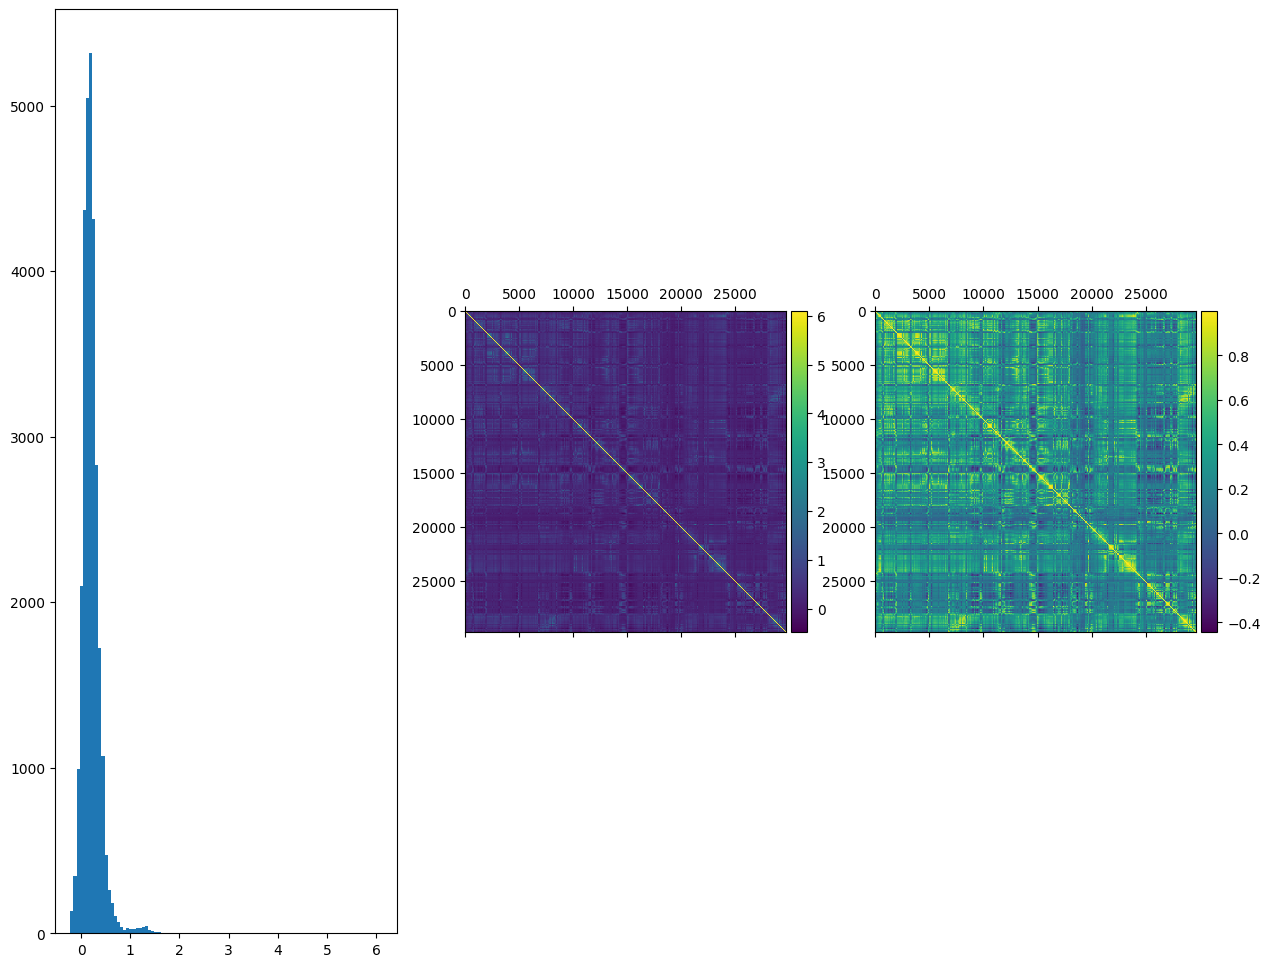

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15,12)) # 4 plots in a row
axs[0].hist(cmat_z[100,:], bins=100)
im=axs[1].matshow(cmat_z); fxdcolorbar(im, ax=axs[1])
im=axs[2].matshow(cmat); fxdcolorbar(im, ax=axs[2])

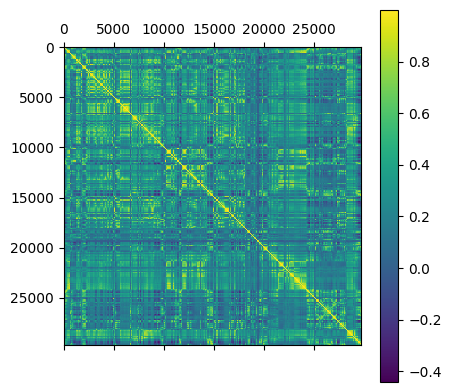

In [74]:
im=plt.matshow(cmat); plt.colorbar(im)

In [ ]:
# Alternative: creation of an affinity matrix ...
#from brainspace.gradient.gradient import compute_affinity
#ca = lambda x: compute_affinity(x, kernel="normalized_angle", sparsity=0.9, gamma=None)
#camat= ca(cmat)
#X, Y = np.meshgrid(pts[1], pts[0])
#A = np.exp(-np.abs(X-Y)**2)

In [14]:
# decompose this group connectivtiy matrix using PCA

pca1 = PCA(n_components=200)
pca1.fit(cmat) #pca1.fit(ca(cmat))
pcat = lambda x: pca1.transform(x); #pcat = lambda x: pca1.transform(ca(x));
#sklearn.decomposition.IncrementalPCA¶
group_comps = pcat(cmat)
print("Resulting components:", group_comps.shape)

# Save components and weights
#np.save("data/group_components.pca200c.npy", group_comps)
#pk.dump(pca1, open("data/group_conmat_pca.200c.pkl","wb"))
!ls -ash data/group_components.pca200c.npy
!ls -ash data/group_conmat_pca.200c.pkl

Resulting components: (29696, 200)
23M data/group_components.pca200c.npy
23M data/group_conmat_pca.200c.pkl


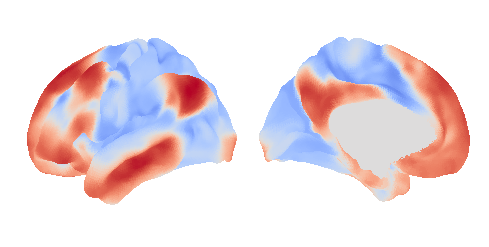

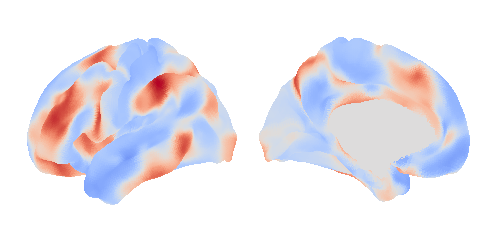

In [15]:
from lib.plotting import plot_29k
group_comps = np.load("data/group_components.pca200c.npy")
plot_29k(group_comps[:, 0], colorbar=None)
plot_29k(group_comps[:, 1], colorbar=None)

# Individual subject example

In [12]:
subj = all_subjs[0]
lh_full_ts = np.concatenate([load_hcp_ts_data("/scratch/users/robert.scholz2/"+\
    rs_file_stub, subj, session, zscore=False, v=1) for session in sessions], axis=0)

print("Shape of full timeseries:", lh_full_ts.shape)
print("Variance along axis 0:", lh_full_ts.var(axis=0).shape, lh_full_ts.var(axis=0))
print("Variance along axis 1:", lh_full_ts.var(axis=1).shape, lh_full_ts.var(axis=1))

# Optional visualization of in which vertices we have the  most variance over time
# plt.hist(lh_full_ts.var(axis=0), bins=100);
# plot_29k(lh_full_ts.var(axis=0), cmap="viridis", colorbar=True, vmin=0, vmax=0.15e7)

/scratch/users/robert.scholz2/HCP_1200/100206/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/scratch/users/robert.scholz2/HCP_1200/100206/MNINonLinear/Results/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/scratch/users/robert.scholz2/HCP_1200/100206/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/scratch/users/robert.scholz2/HCP_1200/100206/MNINonLinear/Results/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Shape of full timeseries: (4800, 29696)
Variance along axis 0: (29696,) [117716.58384153  52712.18660663 130114.33161307 ... 452157.18188029
 496729.3497405  125570.33731073]
Variance along axis 1: (4800,) [4227040.02731017 4238971.95904498 4232881.30586097 ... 3773009.63386925
 3801618.54050846 3772608.42825306]


In [23]:
# Compute individual connectivity maptrix
icmat = np.corrcoef(lh_full_ts.T)
# Group level reference: ((29696, 29696), 0.99999, -0.4413942, 0.27789932, 0.19454728)
print("Individal CMat stats:", icmat.shape, icmat.max(), icmat.min(), icmat.mean(), icmat.std())

Individal CMat stats: (29696, 29696) 1.0 -0.9984454762498377 0.0468787190442503 0.532433834163315


In [ ]:
# Decompose individual connectivty matrix 

from sklearn.decomposition import PCA
pca_indv = PCA(n_components=200)
indiv_comps = pca_indv.fit_transform(icmat)
print("Individal Components:", indiv_comps.shape, pca_indv.explained_variance_ratio_.sum(), pca_indv.explained_variance_.sum())


# align them to the group components via procrustes
group_comps = np.load("data/group_components.pca200c.npy")
print("Group components:", group_comps.shape)

from brainspace.gradient.alignment import ProcrustesAlignment
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
indiv_comps_aligned = alignment.fit([indiv_comps], group_comps).aligned_[0]
print("Aligned Individal Components:", indiv_comps_aligned.shape)

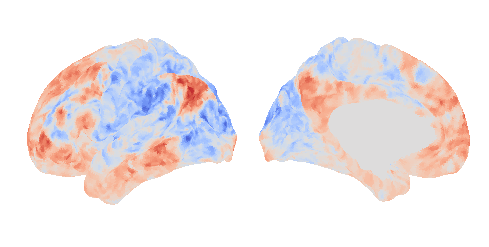

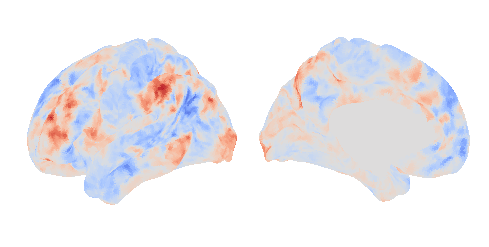

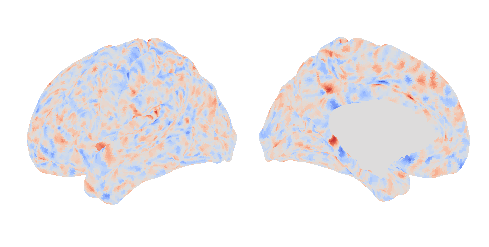

In [98]:
from lib.plotting import plot_29k
plot_29k(indiv_comps_aligned[:, 0], colorbar=None)
plot_29k(indiv_comps_aligned[:, 1], colorbar=None)

In [ ]:
# Alternative apply group connectivity pca downprojection on the individual data
"""
pca = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
print("PCA Group components shape:", pca.components_.shape)
# using the pca that is based on pearson-corr group conmat
icomps = pca.transform(icmat)
# using instead the pca that is based on fishers-z scores group conmat
#icomps = pca.transform(fishers_z(icmat*0.999999999))
icomps = scipy.stats.zscore(icomps, axis=0)
print(icomps.shape)
""";

# Batch for all subjects

reversed using return np.dot(X, self.components_) + self.mean_

In [26]:
all_grads_zgr = {}
all_grads_gr = {}
all_grads_idvpro = {}

In [ ]:
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
#pca = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
#pca_zgr = pk.load(open("data/group_conmat_z_pca.200c.pkl",'rb')) 
#pca_gr = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
group_comps = np.load("data/group_components.pca200c.npy")

n_comps = 200

alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
expl_vars_indv = np.zeros((len(full_subjs), 200))
indv_pcas =[]

for i, subj in tqdm(enumerate(full_subjs), total=len(full_subjs)):
  print(subj)
  if subj in all_grads_zgr.keys(): continue;

  lh_full_ts = np.concatenate([load_hcp_ts_data("/scratch/users/robert.scholz2/"+\
    rs_file_stub, subj, session, zscore=True) for session in sessions], axis=0)

  icmat = np.corrcoef(lh_full_ts.T)
  
  pca_indv = PCA(n_components=n_comps)
  indiv_comps = pca_indv.fit_transform(icmat)
  indiv_comps_aligned = alignment.fit([indiv_comps], group_comps).aligned_[0]
  #icomps_zgr = pca_zgr.transform(fishers_z(icmat*0.999999999))
  #icomps_gr = pca_gr.transform(icmat)
  
  expl_vars_indv[i,:] = pca_indv.explained_variance_ratio_
  print(subj, pca_indv.explained_variance_ratio_.sum().round(3))
  indv_pcas.append(pca_indv)
  np.save("/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated.L.corrcoef.procrAlignGr.pca_var_explained.npy", \
          {"pca_indvs": indv_pcas, "var_expl_ratios" : expl_vars_indv, "subjs":full_subjs[:i+1]});

  #icomps = scipy.stats.zscore(icomps, axis=0)
  #all_grads_zgr[subj] = icomps_zgr.astype(np.float32);
  #all_grads_gr[subj] = icomps_gr.astype(np.float32);
  all_grads_idvpro[subj] = indiv_comps_aligned.astype(np.float32);
  clear_output(wait=True)  
    
  if i % 10==0:
    fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.L.corrcoef.procrAlignGr.npy"
    np.save(fn, all_grads_idvpro)

  8%|▊         | 20/254 [29:44<6:32:51, 100.73s/it]

118124


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [ ]:
# Final saving of complete results

#fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.L.fisherz.commonGroupPCA.npy"
#np.save(fn, all_grads_zgr)
#fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated2.L.corrcoef.commonGroupPCA.npy"
#np.save(fn, all_grads_gr)
    
fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy"
#np.save(fn, all_grads_idvpro)
!ls -ash {fn}

In [60]:
# Z-sore all the gradients
all_grads_idvpro_z = {subj: scipy.stats.zscore(all_grads_idvpro[subj], axis=0) for subj in all_grads_idvpro.keys()}
del all_grads_idvpro

# and save them
fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.zscore.npy"
#np.save(fn, all_grads_idvpro_z)
del all_grads_idvpro_z

# Look at which preprocessed gradients we have
!ls -asht /scratch/users/robert.scholz2/acc_dists/ | head -n 14

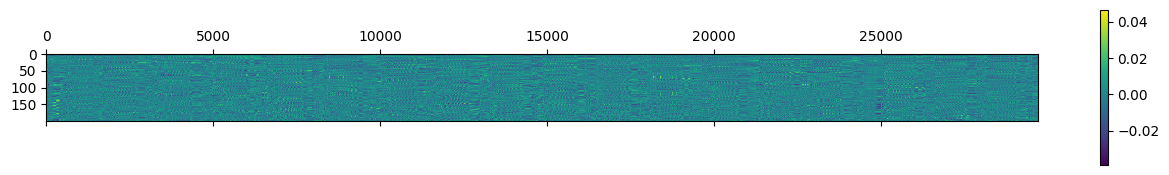

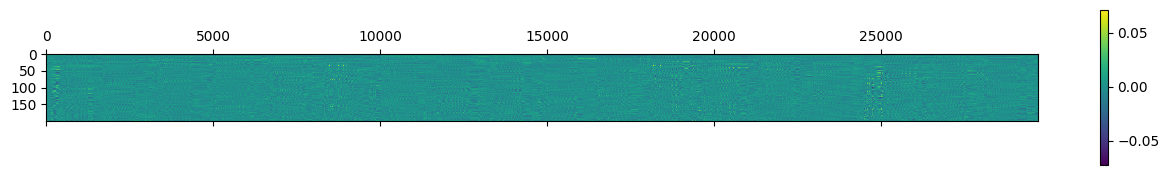

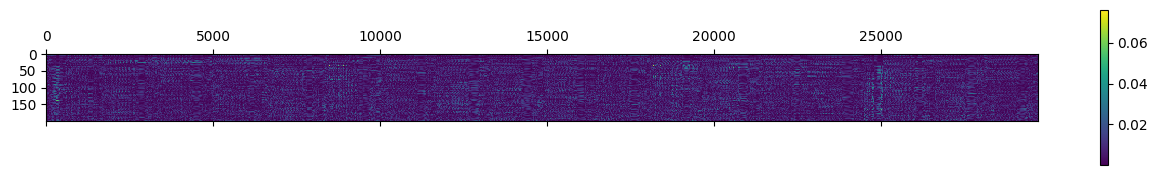

In [25]:
im = plt.matshow(pca_zgr.components_, aspect=10); plt.colorbar(im);
im = plt.matshow(pca_gr.components_, aspect=10); plt.colorbar(im);
im = plt.matshow(np.absolute(pca_zgr.components_-pca_gr.components_), aspect=10); plt.colorbar(im);

# Visualization of Individual Results

In [ ]:
subj="877269"
print(subj)
lh_full_ts = np.concatenate([load_hcp_ts_data("/scratch/users/robert.scholz2/"+\
rs_file_stub, subj, session, zscore=True) for session in sessions], axis=0)
group_comps = np.load("data/group_components.pca200c.npy")
pca_zgr = pk.load(open("data/group_conmat_z_pca.200c.pkl",'rb')) 
pca_gr = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 

n_comps = 200
pca_indv = PCA(n_components=n_comps)
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)

icmat = np.corrcoef(lh_full_ts.T)

indiv_comps = pca_indv.fit_transform(icmat)
indiv_comps_aligned = alignment.fit([indiv_comps], group_comps).aligned_[0]
icomps_zgr = pca_zgr.transform(fishers_z(icmat*0.999999999))
icomps_gr = pca_gr.transform(icmat)

877269


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


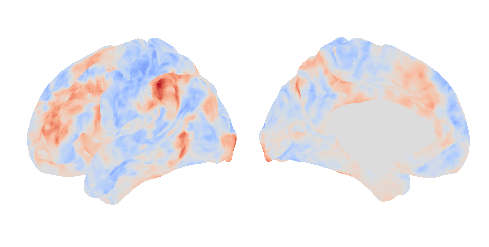

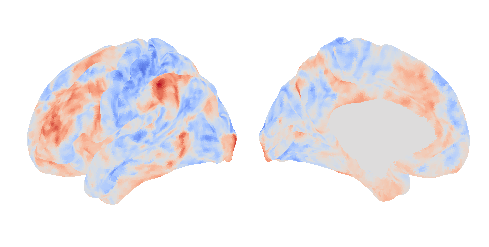

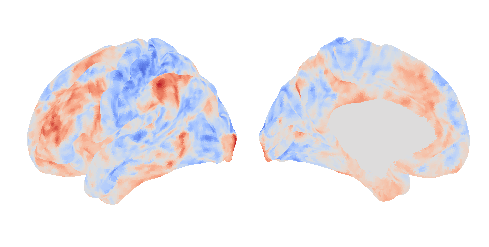

In [ ]:
plot_29k(scipy.stats.zscore(indiv_comps_aligned[:,1]), colorbar=0)
plot_29k(scipy.stats.zscore(icomps_zgr[:,1]), colorbar=0)
plot_29k(scipy.stats.zscore(icomps_gr[:,1]), colorbar=0)

2.162934319518205e-06
8.06948031566747e-17
0.07360447645488268
0.19127904214997196


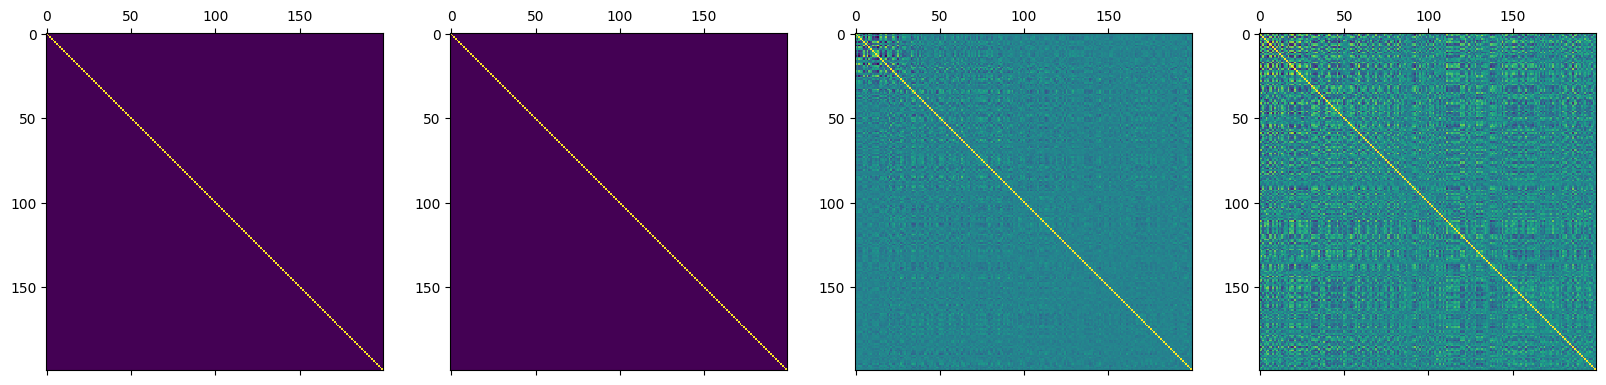

In [98]:
# look at how independent the components are
# result: alignment induces correlation between the components; but less so than reusing group estimate PCA weights
fig, axs = plt.subplots(1,4, figsize=(20,12)) # 4 plots in a row

for ax, data in zip(axs, [group_comps, indiv_comps, indiv_comps_aligned, icomps_zgr]):
  cm =np.corrcoef(scipy.stats.zscore(data, axis=0).T); 
  im = ax.matshow(cm); #plt.colorbar(im)
  average_off_dig_corr = (np.absolute(cm).sum() - np.absolute(np.diag(cm)).sum()) / ((200*200) - 200);
  print(average_off_dig_corr)


## Full Results

In [4]:
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
full_subjs[-4]

'792867'

In [30]:
adir="/scratch/users/robert.scholz2/acc_dists/"
all_grads_zgr = np.load(adir+"all_grads_254_full_unrelated.L.fisherz.commonGroupPCA.npy", allow_pickle=1).item()
all_grads_gr = np.load(adir+"all_grads_254_full_unrelated.L.corrcoef.commonGroupPCA.npy", allow_pickle=1).item()
all_grads_idvpro = np.load(adir+"all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy", allow_pickle=1).item()
print(len(all_grads_zgr.keys()), len(all_grads_gr.keys()), len(all_grads_idvpro.keys()))

254 254 254


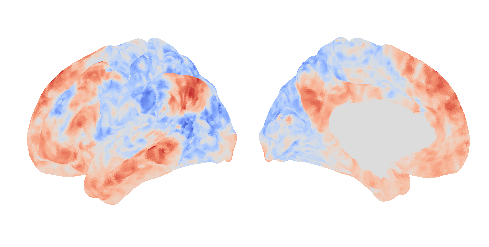

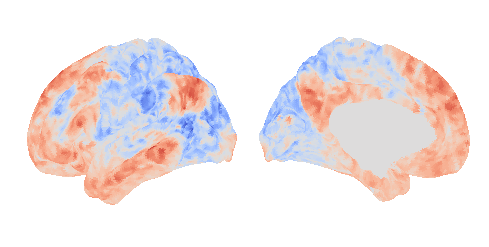

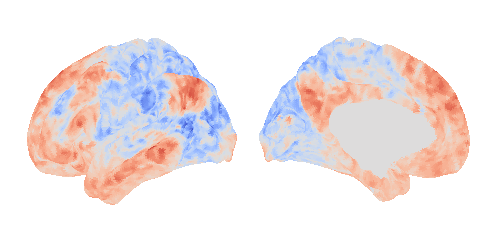

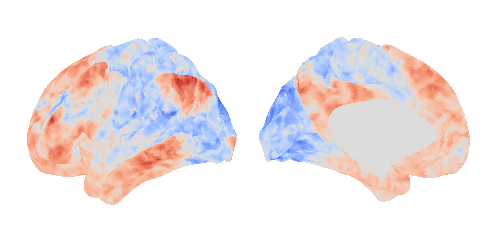

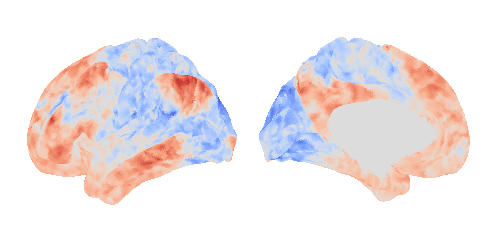

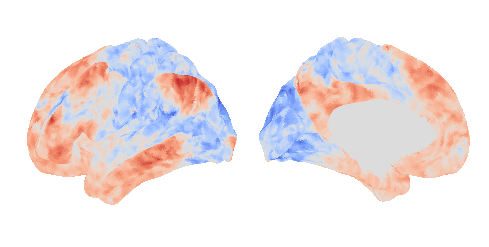

In [46]:
# first grads look super similiar
plot_29k(scipy.stats.zscore(all_grads_idvpro['318637'][:,0]), colorbar=0)
plot_29k(scipy.stats.zscore(all_grads_gr['318637'][:,0]), colorbar=0)
plot_29k(scipy.stats.zscore(all_grads_zgr['318637'][:,0]), colorbar=0)
plot_29k(scipy.stats.zscore(all_grads_idvpro['645450'][:,0]), colorbar=0)
plot_29k(scipy.stats.zscore(all_grads_gr['645450'][:,0]), colorbar=0)
plot_29k(scipy.stats.zscore(all_grads_zgr['645450'][:,0]), colorbar=0)


## Sample loading (for torch NN training)

In [ ]:
import torch
from sklearn.utils import Bunch
from lib.DistanceDataLoading import LazyLoadingDistDataset

dscfg = Bunch(**dict(H = 'L', hemi = 'left', parcell = 'LS08s4', exp_id = 'HCPAllTasks', n_subjs = 100, \
          z_score_task_maps = True, pred_indiv_var_only=False, dist_corr =True, n_batch = "max", n_val="max"))

dscfg.update({"grad_file" : "all_grads_254_full_unrelated.L.fisherz.commonGroupPCA.npy"})

#subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
#n_train_subjs = int(len(subjs)*0.8); 
#train_subj_ids = subjs[:n_train_subjs]

subjsids=['100206', '100610', '101006', '101309', '101915', '102311', '102513'];
training_set = LazyLoadingDistDataset(subjsids, corr_dist=False, z_score_task_maps=False)
# preloades the entire dataset
training_set.init_data_from_file("/scratch/users/robert.scholz2/acc_dists/all_10_tasks_254_full_unrelated.raw.npy", modality="task")
training_set.init_data_from_file("/scratch/users/robert.scholz2/acc_dists/"+ dscfg.grad_file, modality="dist")
if dscfg.z_score_task_maps: training_set.ensure_z_score_task_maps()
train_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)

x,y = next(iter(train_loader))
print(x.shape,y.shape)